# Ant Colony Optimization

The first thing we will do is write a simple script that simulates the foraging behaviour of ants, adapted from the following sources on Ant Colony Optimization (ACO)

1. [ACO_Wiki](https://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms)
2. [Continious Orthogonal Ant Optimazation](https://link.springer.com/article/10.1007%2Fs11390-008-9111-5)

## Create a moving Agent

The first step in creating out ACO algorithm is to create a moving agent that changes direction with subtle randomness. To do this we implement the two classes below. The first class is the field the agents will move in, and the second is the actual agent class with some basic movement functionality that includes the ability to change direction after some time.


In [49]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.animation as animation
from fiblat import sphere_lattice as sphere

# Set up a seed
SEED = 1234567890
np.random.seed(SEED)

In [77]:
# Global Helper functions
def unit(x):
    '''Returns a unit vector for x'''
    if np.dot(x,x) == 0: return 0
    return x/np.sqrt(np.dot(x,x))

# Creates random evenly spaced points on a unit n-sphere
def points_on_sphere(n:int,points:int):
    if n == 2:
        theta = np.linspace(0,2*np.pi,points)
        return np.array([np.cos(theta),np.sin(theta)]).T

    else: return np.array(sphere(n,points))

# We will first create a class for a simple field for everything to live in
class Field:

    # Constructor
    def __init__(self,bounds:np.array=np.array([[0,1],[0,1]]),steps=[100,100],function = lambda x: 0):
        # The bounds of the field
        self.bounds = bounds
        self.dim = len(bounds)

        # The function
        self.function = function

        # Pheromone Matrix
        self.pheromones = np.zeros([*steps,2])
        self.h = np.array([(b[1] - b[0])/step for b,step in zip(bounds,steps)])


    # Generate a random position within the map
    def random_position(self):
        return np.array([ x*abs(self.bounds[i,1]-self.bounds[i,0]) + min(self.bounds[i]) for i,x in enumerate(np.random.rand(self.bounds.shape[0]))])

    # return a random unit vector with the dimensions of the borad
    def random_unit_vector(self):
        return unit(np.random.rand(self.bounds.shape[0])*2-np.array([1,1]))

    # Checks if a number is inside the box
    def inside(self,x:np.array):
        ans = True
        for i in range(len(x)): ans = ans and (x[i] <= self.bounds[i,1]) and (x[i] >= self.bounds[i,0])
        return ans

    # Get the index of a position vector inside the field on the pheromone array
    def index(self,x:np.array):
        if not self.inside(x): raise('The vector is not inside the field')
        return tuple(np.floor((x-self.bounds.T[0])/self.h + 0.5).astype(dtype=np.int64))

    # This adds a pheromone to the pheromone matrix
    def add_pheromone(self,x:np.array,value:float=1,time:float=0):
        self.pheromones[self.index(x)] = np.array([value,time])

# Create a class for an agent
class Agent:
    ID_cnt = 0          # Static variable to hold the IDs

    # Constructor
    def __init__(self,ID:int = -1, pos:np.array = np.array([None,None]), field:Field = Field()):
        
        # Assign a unique ID
        self.ID = Agent.ID_cnt if ID == -1 else ID
        Agent.ID_cnt += 1

        # Assign the field variable
        self.field = field

        # Determine if to create a random position
        self.pos = self.field.random_position() if (pos == np.array([None,None])).all() else pos

        # It's velocity will also be a vector initialized at 0
        self.vel = np.zeros(self.pos.shape)
        self.desired_vel = np.zeros(self.pos.shape)

        # State will tell us if this is a scout or worker
        # Scout   : 0
        # Worker-1: 1
        # Worker-2: 2, etc.
        self.state = 0

    # This will update the position based on the velocity
    def move(self,dt):
        self.pos = self.vel * dt + self.pos

    # This function will sense the direction of minimum gradient
    def grad_direction(self,radius:float=1,Nsamples:int=10):
        # Get the points to search
        test_points = self.pos+points_on_sphere(self.field.dim,Nsamples)*radius

        # Get the gradient around that ring
        grad = (self.field.function(test_points) - self.field.function(self.pos)*np.ones(len(test_points)))

        # Pick the minimum and return its direction
        return (test_points[np.argmin(grad)]-self.pos)/radius*abs(min(grad))


    # This will update the velocity using certain randomness
    def update_velocity(self,dt,acc_magnitude=1,desired_speed=1,randomness=0.5,gradient_strength=1,grad_radius:float=1,grad_samples:int=10):
        # First we update the desired velocity
        # Get the preferential gradient direction
        grad = self.grad_direction(radius=grad_radius,Nsamples=grad_samples)
        self.desired_vel = unit(self.field.random_unit_vector()*randomness + self.desired_vel + grad*gradient_strength) * desired_speed

        # After having a new desired speed we calculate the acceleration required to reach that speed
        acc = unit(self.desired_vel - self.vel) * acc_magnitude

        # Finally, update the velocity based on the past accelleration
        self.vel = self.vel + acc*dt


In [78]:
# Now we test Let's create a function that would put an agent in a field and run it with our parameters

# Agent motion properties
acc_magnitude       = 2
desired_speed       = 1
randomness          = 10
dt                  = 0.01
max_time            = 10
gradient_strength   =1
grad_radius         =1
grad_samples        =10
s                   = 0.4
func                = lambda x: -10*np.exp(-x.dot(x)/s**2)

def run_one_agent(field:Field,dt=dt,max_time=max_time,acc_magnitude=acc_magnitude,desired_speed=desired_speed,randomness=randomness,gradient_strength=gradient_strength,grad_radius=grad_radius,grad_samples=grad_samples,pos=np.array([0.5,0.5])):
    # Create an agent
    agent = Agent(pos=pos,field=field)      # pos=np.array([0.5,0.5]),

    # Simulate the agent's motion for some arbitrary time
    time = np.arange(0,max_time,dt)
    
    # An array to solve the position
    pos = [agent.pos]

    # Simulate
    for t in time:
        agent.update_velocity(dt,acc_magnitude,desired_speed,randomness,gradient_strength,grad_radius,grad_samples)
        agent.move(dt)

        pos.append(agent.pos)

    pos = np.array(pos)

    return pos

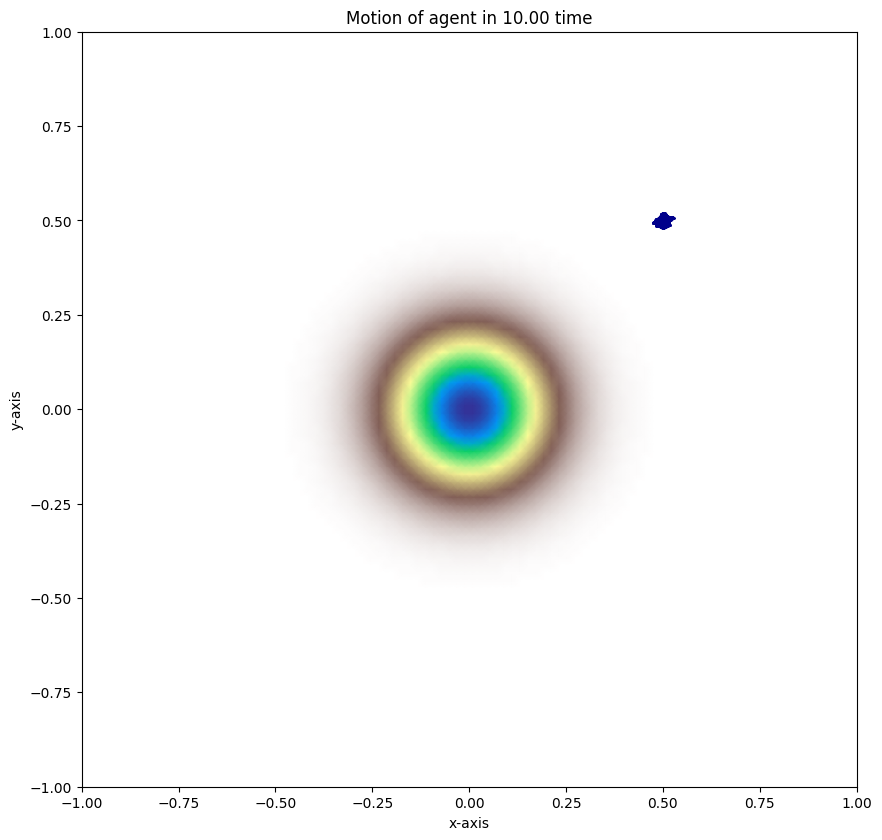

In [129]:
# Agent motion properties
acc_magnitude       = 2
desired_speed       = 0.5
randomness          = 1e-0
dt                  = 0.01
max_time            = 10
gradient_strength   = 10000
grad_radius         = 1e-4
grad_samples        = 50
bounds              = np.array([[-1,1],[-1,1]])
steps               = [100,100]
s                   = 0.2
pos                 = np.array([0.5,0.5]) # np.array([None,None])
def func(x): 
    if len(x.shape) == 1:
        p1 = np.array([0.5,0.5])
        p2 = np.array([-0.5,-0.5])
        return -np.exp(-np.dot(x-p1,x-p1)/s**2) -np.exp(-np.dot(x-p2,x-p2)/s**2)
    else:
        return np.array([func(xi) for xi in x])
def F (x,y): return -np.exp(-(x**2 + y**2)/s**2)

# Now plot the position array
field = Field(bounds=bounds,steps=steps,function=func)

pos = run_one_agent(field,dt,max_time,acc_magnitude,desired_speed,randomness,gradient_strength,grad_radius,grad_samples,pos)

# Create the figure and setup athe axis
fig = plt.figure(figsize=(10,10),dpi=100)
ax  = fig.add_subplot(111)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('Motion of agent in %.2f time'%max_time)
ax.set_xlim(*field.bounds[0])
ax.set_ylim(*field.bounds[1])

# Plot the mesh
x = np.linspace(*bounds[0],100)
y = np.linspace(*bounds[1],100)
X,Y = np.meshgrid(x,y)
Z = F(X,Y)
ax.pcolormesh(X,Y,Z,cmap='terrain', shading='gouraud')

# plot the position
ax.scatter(*(pos.T),s=1,marker='x',c='darkblue');

In [130]:
# A counter for our animations
anim_cnt = 0

100%|██████████| 250/250 [02:06<00:00,  1.97it/s]


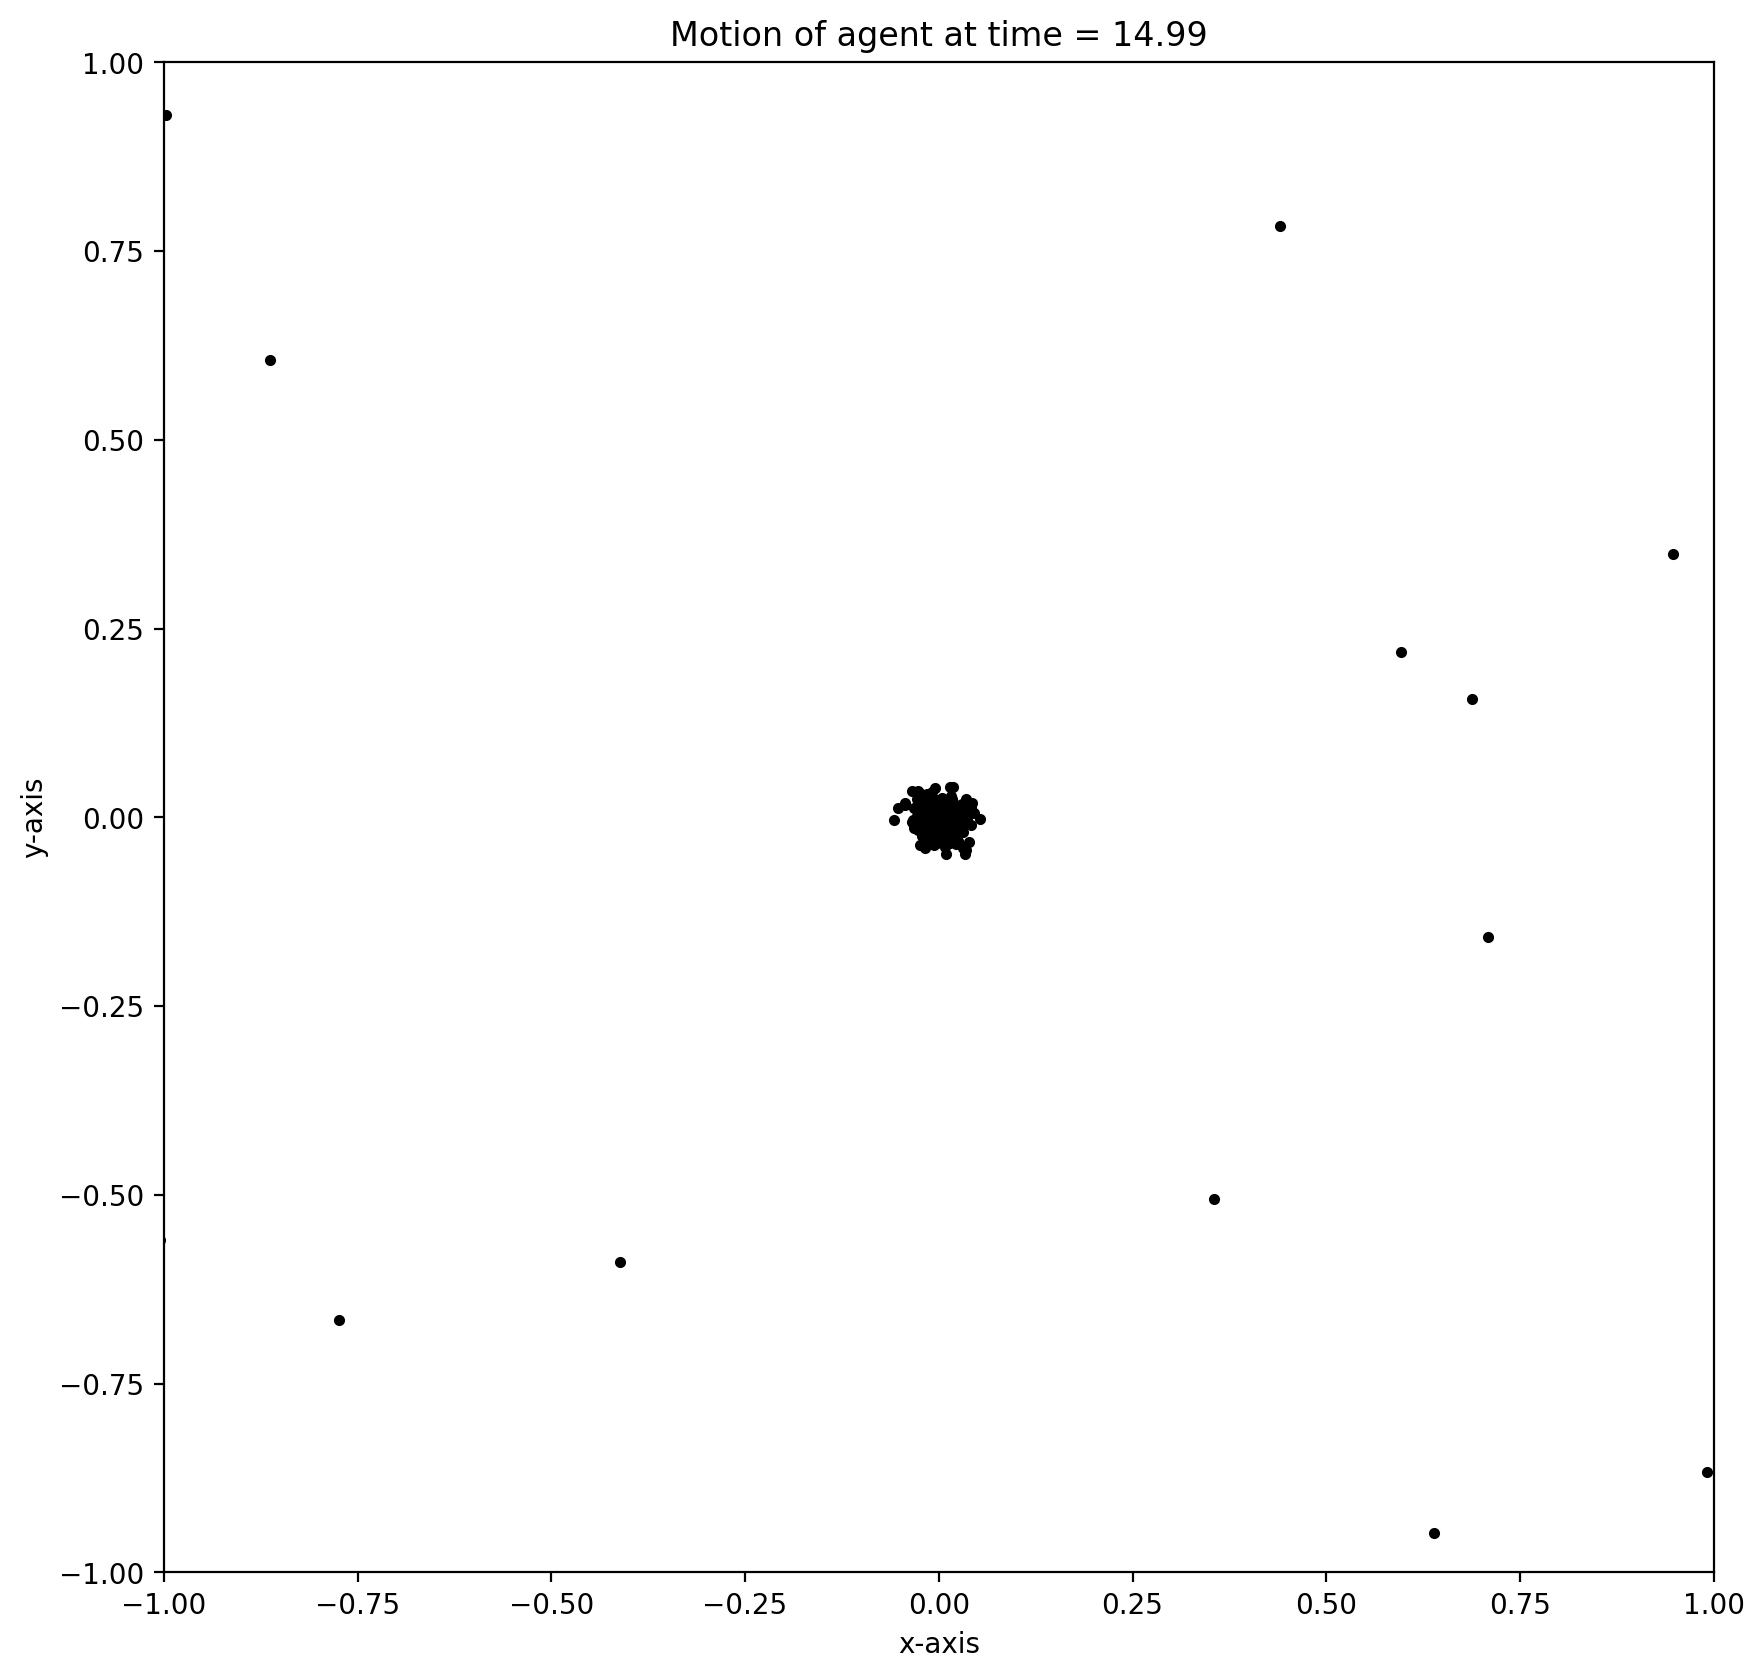

In [131]:
# We can create a quick animation just to make sure

# Agent motion properties
N_agents = 250
acc_magnitude       = 2
desired_speed       = 0.5
randomness          = 1e-0
dt                  = 0.01
max_time            = 15
gradient_strength   = 10000
grad_radius         = 1e-4
grad_samples        = 50
bounds              = np.array([[-1,1],[-1,1]])
steps               = [100,100]
s                   = 0.4
pos                 = np.array([None,None])
def func(x): 
    if len(x.shape) == 1:
        p1 = np.array([0.5,0.5])
        p2 = np.array([-0.5,-0.5])
        return -np.exp(-np.dot(x-p1,x-p1)/s**2) -np.exp(-np.dot(x-p2,x-p2)/s**2)
    else:
        return np.array([func(xi) for xi in x])
def F (x,y): return -np.exp(-(x**2 + y**2)/s**2)

# Now plot the position array
field = Field(bounds=bounds,steps=steps,function=func)

time = np.arange(0,max_time,dt)
posA = np.array([run_one_agent(field,dt,max_time,acc_magnitude,desired_speed,randomness,gradient_strength,grad_radius,grad_samples,pos) for i in tqdm(range(N_agents))])

pos = []
for j in range(len(posA[0])):
    pos.append([])
    for i in range(len(posA)):
        pos[-1].append(posA[i][j])

pos = np.array(pos)

# Now we will define a figure
# Create the figure and setup athe axis
fig = plt.figure(figsize=(10,10),dpi=200)
ax  = fig.add_subplot(111)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('Motion of agent at time = %.2f'%time[0])
ax.set_xlim(*field.bounds[0])
ax.set_ylim(*field.bounds[1])

# Plot the mesh
x = np.linspace(*bounds[0],100)
y = np.linspace(*bounds[1],100)
X,Y = np.meshgrid(x,y)
Z = F(X,Y)
# ax.pcolormesh(X,Y,Z,cmap='terrain', shading='gouraud')

# Now the plot element
dot, = plt.plot([],[],'ko',ms=3)

# Define our update function
def update(i):
    # Get some variables from the global scope
    global ax,dot,pos,time

    # Set our new data
    dot.set_data(pos[i].T[0],pos[i].T[1])
    ax.set_title('Motion of agent at time = %.2f'%time[i])

    return dot,

# Animate!
anim = animation.FuncAnimation(fig,update,frames=len(time),blit=True)
writer = animation.writers['ffmpeg'](fps=60)
anim.save('Animations/3_Particle_Test-%d.mp4'%anim_cnt,writer=writer,dpi=200)
anim_cnt+=1

## Adding a sense of direction

Now that we have implemented a way for the ants to move randomply around a terrain we should add a sense of directionality to them. How do we do this? We will utilize pheromone trails that different nodes will follow.

To do this effectively, we will have two basic states an agent can be in. One is a scout, the other is a worker.

1. The scouts wander around following the curvature of the original function - pheromones.
2. The scout becomes a worker if they can "fill in" the curvature with their pheromone. Then they stay there.


In [20]:
steps=[2,3]
x = np.zeros([*steps,2])

In [74]:
x = np.arange(1,10).reshape(3,3)

In [88]:
y = np.array([0,1])
x[tuple(y)]

2